#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2018


# Homework 2:  Link Analysis -- HITS + SEO

### 100 points [5% of your final grade]

### Due: Sunday, February 25, 2018 by 11:59pm

*Goals of this homework:* Explore real-world challenges of building a graph (in this case, from tweets), implement and test HITS algortihm over this graph, and investigate factors that impact a page's rank on Google and Bing.

*Submission Instructions:* To submit your homework, rename this notebook as YOUR_UIN_hw2.ipynb. Submit this notebook via ecampus. Your notebook should be completely self-contained, with the results visible in the notebook. 

*Late submission policy:* For this homework, you may use up to three of your late days, meaning that no submissions will be accepted after Wednesday, February 28, 2018 at 11:59pm.

# Part 1: HITS (70 points)

## A re-Tweet Graph

In this assignment, we're going to adapt the classic HITS approach to allow us to find not the most authoritative web pages, but rather to find significant Twitter users. So, instead of viewing the world as web pages with hyperlinks (where pages = nodes, hyperlinks = edges), we're going to construct a graph of Twitter users and their retweets of other Twitter users (so user = node, retweet of another user = edge). Over this Twitter-user graph, we can apply the HITS approach to order the users by their hub-ness and their authority-ness.

Here is a toy example. Suppose you are given the following four retweets:

* **userID**: diane, **text**: "RT ", **sourceID**: bob
* **userID**: charlie, **text**: "RT Welcome", **sourceID**: alice
* **userID**: bob, **text**: "RT Hi ", **sourceID**: diane
* **userID**: alice, **text**: "RT Howdy!", **sourceID**: parisa

There are four short tweets retweeted by four users. The retweet between users form a directed graph with five nodes and four edges. E.g., the "diane" node has a directed edge to the "bob" node.

You should build a graph by parsing the tweets in the file we provide called *HITS.json*.

**Notes:**

* You may see some weird characters in the content of tweets, just ignore them. 
* The edges are weighted and directed. If Bob retweets Alice's tweets 10 times, there is an edge from Bob to Alice with weight 10, but there is not an edge from Alice to Bob.
* If a user retweets herself, ignore it.
* Correctly parsing screen_name in a tweet is error-prone. Use the id of the user (this is the user who is re-tweeting) and the id of the user in the retweeted_status field (this is the user who is being re-tweeted; that is, this user created the original tweet).
* Later you will need to implement the HITS algorithm on the graph you build here.


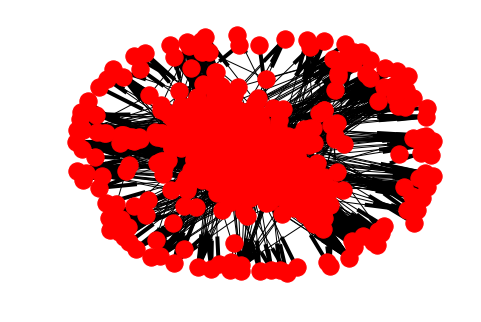

In [2]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt

train_file = './HITS.json'
G = nx.DiGraph()
jsons = []

with open(train_file) as f:
    for line in f:
        jsons.append(line)  # appended the jsons in one list

for js in jsons:
    retweet = json.loads(js)
    # u and v are the nodes around an edge
    u = retweet["user"]["id"]
    v = retweet["retweeted_status"]["user"]["id"]
    if (u == v):
        continue # skipping self loops
    G.add_node(u)
    G.add_node(v)
    if (G.has_edge(u,v)):
        G[u][v]['weight'] += 1
    else:
        G.add_edge(u,v,weight=1)
    
# nx.draw(G, with_labels=True, font_weight='bold')
nx.draw(G)
plt.show()

We will not check the correctness of your graph. However, this will affect the HITS results later.

## HITS Implementation

Your program will return the top 10 users with highest hub and authority scores. The **output** should be like:

Hub Scores

* user1 - score1
* user2 - score2
* ...
* user10 - score10

Authority Scores

* user1 - score1
* user2 - score2
* ...
* user10 - score10

You should follow these **rules**:

* Assume all nodes start out with equal scores.
* It is up to you to decide when to terminate the HITS calculation.
* There are HITS implementations out there on the web. Remember, your code should be **your own**.


**Hints**:
* If you're using the matrix style approach, you should use [numpy.matrix](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.html).
* Scipy is built on top of Numpy and has support for sparse matrices. You most likely will not need to use Scipy unless you'd like to try out their sparse matrices.
* If you choose to use Numpy (and Scipy), please make sure your Anaconda environment include their latest versions.
* Test your parsing and HITS calculations using a handful of tweets, before moving on to the entire file we provide.
* We will evaluate the user ranks you provide as well as the quality of your code. So make sure that your code is clear and readable.

In [3]:
# Method 1: Using the method in the Manning book

import numpy as np
import scipy.sparse
from collections import OrderedDict

# Preferred to set max number of iterations rather than
# error bound because as I read sometimes error may not 
# converge for some graph structures
max_iter = 10000

n = G.number_of_nodes()
adj_mat = nx.to_scipy_sparse_matrix(G)
At_A = adj_mat.T * adj_mat
A_At = adj_mat * adj_mat.T
a = np.ones((n,1))/n
h = np.ones((n,1))/n

for i in range(max_iter):
    h = A_At * h
    h = h/h.sum()
    a = At_A * a
    a = a/a.sum()

hubs = dict(zip(G.nodes(),h.flatten()))
auths = dict(zip(G.nodes(),a.flatten()))
hubs_sorted_by_value = OrderedDict(sorted(hubs.items(), key=lambda x: x[1], reverse=True))
auths_sorted_by_value = OrderedDict(sorted(auths.items(), key=lambda x: x[1], reverse=True))

i = 1
print('Top hubs:')
for k, v in hubs_sorted_by_value.items():
    print('#' + str(i) + ' ' + str(k) + ' - ' + str(v))
    i += 1
    if (i == 11):
        break
i = 1
print
print('Top auths:')
for k, v in auths_sorted_by_value.items():
    print('#' + str(i) + ' ' + str(k) + ' - ' + str(v))
    i += 1
    if (i == 11):
        break

Top hubs:
#1 3068706044 - 0.0646100279655
#2 3093940760 - 0.0307083569253
#3 2194518394 - 0.0269457105353
#4 2862783698 - 0.0210057359503
#5 3092183276 - 0.0176807458856
#6 3029724797 - 0.0173148715025
#7 2990704188 - 0.0153181951952
#8 3001500121 - 0.0150167967206
#9 3086921438 - 0.0133914011178
#10 3042686360 - 0.0129883300683

Top auths:
#1 3042570996 - 0.107091594098
#2 3065514742 - 0.0969830081961
#3 1638625987 - 0.0872917402611
#4 3077733683 - 0.0563535112037
#5 3039321886 - 0.0441115384479
#6 3077695572 - 0.0239665336199
#7 3019659587 - 0.0222644055992
#8 1358345766 - 0.0192763014045
#9 3061155846 - 0.0184806794405
#10 3092580049 - 0.0184205004778


In [4]:
# Method 2: As given in Wikipedia
# Summing up the interleaved updated
# values of hubs and authorities

A = nx.to_scipy_sparse_matrix(G)
A_t = A.transpose()
n = G.number_of_nodes()
h = np.ones(n)/n
a = np.ones(n)/n
max_iter = 10000

for i in range(max_iter):
    a = A_t*h
    a = a/a.max(axis=0)
    h = A*a
    h = h/h.max(axis=0)
        
hubs = dict(zip(G.nodes(),h.flatten()))
auths = dict(zip(G.nodes(),a.flatten()))
hubs_sorted_by_value = OrderedDict(sorted(hubs.items(), key=lambda x: x[1], reverse=True))
auths_sorted_by_value = OrderedDict(sorted(auths.items(), key=lambda x: x[1], reverse=True))

i = 1
print('Top hubs:')
for k, v in hubs_sorted_by_value.items():
    print('#' + str(i) + ' ' + str(k) + ' - ' + str(v))
    i += 1
    if (i == 11):
        break
i = 1
print
print('Top auths:')
for k, v in auths_sorted_by_value.items():
    print('#' + str(i) + ' ' + str(k) + ' - ' + str(v))
    i += 1
    if (i == 11):
        break

Top hubs:
#1 3068706044 - 1.0
#2 3093940760 - 0.475287782598
#3 2194518394 - 0.417051522555
#4 2862783698 - 0.325115722927
#5 3092183276 - 0.27365327709
#6 3029724797 - 0.267990465997
#7 2990704188 - 0.237086961228
#8 3001500121 - 0.232422074305
#9 3086921438 - 0.207265056826
#10 3042686360 - 0.201026535312

Top auths:
#1 3042570996 - 1.0
#2 3065514742 - 0.905608035937
#3 1638625987 - 0.81511290402
#4 3077733683 - 0.526217876188
#5 3039321886 - 0.411904770114
#6 3077695572 - 0.223794722843
#7 3019659587 - 0.207900590021
#8 1358345766 - 0.179998267529
#9 3061155846 - 0.172568907917
#10 3092580049 - 0.172006968736


# Part 2: Search Engine Optimization (30 + 5 points)

For this part, your goal is to put on your "[search engine optimization](https://en.wikipedia.org/wiki/Search_engine_optimization)" hat. Your job is to create a webpage that scores highest for the query: **kbeznak parmatonic** --- two terms, lower case, no quote. As of today (Feb 16, 2018), there are no hits for this query on either Google or Bing. Based on our discussions of search engine ranking algorithms, you know that several factors may impact a page's rank. Your goal is to use this knowledge to promote your own page to the top of the list.

What we're doing here is a form of [SEO contest](https://en.wikipedia.org/wiki/SEO_contest). While you have great latitude in how you approach this problem, you are not allowed to engage in any unethical or illegal behavior. Please read the discussion of "white hat" versus "black hat" SEO over at [Wikipedia](https://en.wikipedia.org/wiki/Search_engine_optimization#White_hat_versus_black_hat_techniques).


**Rules of the game:**

* Somewhere in the page (possibly in the non-viewable source html) you must include your name or some other way for us to identify you (e.g., your NetID, but not the UIN!).
* Your target page may only be a TAMU student page, a page on your own webserver, a page on a standard blog platform (e.g., wordpress), or some other primarily user-controlled page
* Your target page CAN NOT be a twitter account, a facebook page, a Yahoo Answers or similar page
* No wikipedia vandalism
* No yahoo/wiki answers questions
* No comment spamming of blogs
* If you have concerns/questions/clarifications, please post on Piazza and we will discuss

For your homework turnin for this part, you should provide us the URL of your target page and a brief discussion (2-4 paragraphs) of the strategies you are using. We will issue the query and check the rankings at some undetermined time in the next couple of weeks. You might guess that major search engines take some time to discover and integrate new pages: if I were you, I'd get a target page up immediately.

**Grading:**

* 5 points for providing a valid URL
* 20 points for a well-reasoned discussion of your strategy
* 5 points for your page appearing in the search results by Google or Bing (no matter how is the ranking)

** Bonus: **
* 1 point for your page appearing in the top-20 on Google or Bing
* 1 more point for your page appearing in the top-10 on Google or Bing
* 1 more point for your page appearing in the top-5 on Google or Bing
* 2 more points for your page being ranked first by Google or Bing. And, a vigorous announcement in class, and a high-five for having the top result!

What's the URL of your page?

## URL : https://kbeznakparmatonic5.wordpress.com/

What's your strategy? (2-4 paragraphs)


I started with adding a webpage on my home people.tamu.edu page about the target topic. Both the website had a lot more than plain HTML to make the website look appealing. 

All the backlink pages had anchor texts which was a hyperlink pointing to my blog about the target word. In both the pages the title tags were started with the target keyword. The title of the article defines its content, and as such, a keyword rich title holds greater weight with Google and Bing. Besides, the closer it is to the beginning of the title tag, the more weight it has. 

In all the blogs I used outbound links to grow it in a form of an informational hub as well. It probably shows search engines that the article is both valid and informative. The meta decription for each page contained the target keyword to incorporate more higher weight of that page. Having said that I provided more meta descriptions in pages (like TAMU page) that back link to the blog page. The target keyword was obviously kept in the URL. 

To ensure that the user tend to stay on my blog, I created internal linking in the webpages of the blog so that, even though by infinitesimal amount, the pagerank (and therefore the probability of staying on the page) increased. 